# Inference

this notebook runs inference for all the surgical action classifier models including the baseline. 
it includes setup, loading a trained model, running metrics, visualizations, speed benchmarking.


In [16]:
from dataset import ClipsDataset, get_val_transform
import time
import numpy as np
import torch
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import (
    f1_score, precision_score, recall_score, accuracy_score,
    classification_report, confusion_matrix
)
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models
from dataset import ClipsDataset, get_val_transform
import importlib.util, os, sys
from pathlib import Path

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATA_PATH = "/home/zhadiger/Desktop/data_preprocessing/dataset"
BATCH_SIZE = 8
NUM_WORKERS = 4

CLASS_NAMES = ['AbdominalEntry', 'HookCut', 'LocPanoView', 'Needle', 
               'PanoView', 'Suction', 'UseClipper']

test_csv = "/home/zhadiger/Desktop/data_preprocessing/test.csv"

test_ds = ClipsDataset(
    data_path="/home/zhadiger/Desktop/data_preprocessing/dataset",
    csv_file=test_csv,
    transform=get_val_transform(),
    resize_shape=(224, 224),
    time_size=16
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if DEVICE == "cuda" else False
)

print(f"test dataset loaded: {len(test_ds)} samples")
print(f"test batches: {len(test_loader)}")

test dataset loaded: 631 samples
test batches: 79


In [17]:
# Metric evaluation functions

@torch.no_grad()
def collect_predictions(model, loader, device):
    """Collect all predictions and labels from a dataloader"""
    model.eval()
    all_labels = []
    all_preds = []
    all_logits = []
    
    for clips, labels in loader:
        clips = clips.to(device)
        logits = model(clips)
        preds = logits.argmax(dim=1)
        
        all_labels.append(labels.cpu())
        all_preds.append(preds.cpu())
        all_logits.append(logits.cpu())
    
    all_labels = torch.cat(all_labels, dim=0).numpy()
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_logits = torch.cat(all_logits, dim=0).numpy()
    
    return all_labels, all_preds, all_logits

def compute_metrics(y_true, y_pred, class_names=None):
    """Compute comprehensive classification metrics"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_macro': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'precision_weighted': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'recall_macro': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'recall_weighted': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1_micro': f1_score(y_true, y_pred, average='micro', zero_division=0),
    }
    
    # Per-class metrics
    if class_names:
        report = classification_report(y_true, y_pred, target_names=class_names, 
                                      output_dict=True, zero_division=0)
        metrics['per_class'] = report
    
    return metrics

def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix", normalize=True):
    """Plot confusion matrix with annotations"""
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        cm_display = cm_norm
        fmt = '.2f'
        title = f"{title} (Normalized)"
    else:
        cm_display = cm
        fmt = 'd'
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_display, annot=True, fmt=fmt, cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Proportion' if normalize else 'Count'})
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return cm

def print_metrics_summary(metrics, dataset_name="Test"):
    """Print formatted metrics summary"""
    print(f"\n{'='*60}")
    print(f"{dataset_name} Set Metrics Summary")
    print(f"{'='*60}")
    print(f"Accuracy:           {metrics['accuracy']:.4f}")
    print(f"\nMacro Metrics:")
    print(f"  Precision:        {metrics['precision_macro']:.4f}")
    print(f"  Recall:           {metrics['recall_macro']:.4f}")
    print(f"  F1-Score:         {metrics['f1_macro']:.4f}")
    print(f"\nWeighted Metrics:")
    print(f"  Precision:        {metrics['precision_weighted']:.4f}")
    print(f"  Recall:           {metrics['recall_weighted']:.4f}")
    print(f"  F1-Score:         {metrics['f1_weighted']:.4f}")
    print(f"\nMicro F1-Score:     {metrics['f1_micro']:.4f}")
    print(f"{'='*60}\n")

print("Evaluation functions loaded successfully!")


Evaluation functions loaded successfully!


## inference speed benchmarking

- warm up the model to stabilize timings.
- measure batch latency and compute throughput and per-sample latency.
- helpful for deployment sizing and batch size tuning.

In [18]:
# benchmarking utilities: measure inference throughput and latency

def benchmark_inference(model, loader, device, warmup_batches=5, num_batches=50):
    """
    benchmark inference speed of the model
    - warms up to stabilize gpu clocks/caches
    - measures batch times and derives throughput + latency
    """
    model.eval()
    
    # warmup helps get realistic steady-state numbers
    print(f"running {warmup_batches} warmup batches...")
    with torch.no_grad():
        for i, (clips, _) in enumerate(loader):
            if i >= warmup_batches:
                break
            clips = clips.to(device)
            _ = model(clips)
            if device == "cuda":
                torch.cuda.synchronize()
    
    # timed runs
    print(f"benchmarking {num_batches} batches...")
    batch_times = []
    total_samples = 0
    
    with torch.no_grad():
        for i, (clips, _) in enumerate(loader):
            if i >= num_batches:
                break
            
            batch_size = clips.size(0)
            clips = clips.to(device)
            
            # measure end-to-end batch latency
            if device == "cuda":
                torch.cuda.synchronize()
            start = time.perf_counter()
            
            _ = model(clips)
            
            if device == "cuda":
                torch.cuda.synchronize()
            end = time.perf_counter()
            
            batch_time = end - start
            batch_times.append(batch_time)
            total_samples += batch_size
    
    batch_times = np.array(batch_times)
    
    # summarize speed metrics
    metrics = {
        'total_samples': total_samples,
        'total_time': batch_times.sum(),
        'mean_batch_time': batch_times.mean(),
        'std_batch_time': batch_times.std(),
        'min_batch_time': batch_times.min(),
        'max_batch_time': batch_times.max(),
        'median_batch_time': np.median(batch_times),
        'throughput_fps': total_samples / batch_times.sum(),
        'mean_sample_time': batch_times.sum() / total_samples,
        'mean_latency_ms': (batch_times.mean() / BATCH_SIZE) * 1000,
    }
    
    return metrics

print("inference speed evaluation functions loaded!")

inference speed evaluation functions loaded!


In [19]:
def evaluation(test_ds, test_loader, model, DEVICE, CLASS_NAMES):
    # evaluate on the test set and print metrics
    print("starting evaluation on test set...")
    print(f"evaluating {len(test_ds)} samples...")

    # collect predictions and logits across the loader
    y_true, y_pred, logits = collect_predictions(model, test_loader, DEVICE)

    print(f"\npredictions collected:")
    print(f"  true labels shape: {y_true.shape}")
    print(f"  predictions shape: {y_pred.shape}")
    print(f"  logits shape: {logits.shape}")

    # compute summary metrics and per-class details
    metrics = compute_metrics(y_true, y_pred, class_names=CLASS_NAMES)

    # print high-level summary
    print_metrics_summary(metrics, dataset_name="Test")

    # dump per-class precision/recall/f1 if available
    if 'per_class' in metrics:
        print("\nper-class metrics:")
        print(f"{'Class':<20} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
        print("="*70)
        for class_name in CLASS_NAMES:
            if class_name in metrics['per_class']:
                p = metrics['per_class'][class_name]['precision']
                r = metrics['per_class'][class_name]['recall']
                f1 = metrics['per_class'][class_name]['f1-score']
                s = metrics['per_class'][class_name]['support']
                print(f"{class_name:<20} {p:<12.4f} {r:<12.4f} {f1:<12.4f} {s:<10.0f}")

    print("\nevaluation complete!")
    
    return y_true, y_pred

In [20]:
def run_speed_benchmark(model, time_size, test_loader, resize_shape, DEVICE, BATCH_SIZE):
    # run the speed benchmark and print a friendly summary
    print(f"{'='*70}")
    print("inference speed evaluation")
    print(f"{'='*70}")
    print(f"device: {DEVICE}")
    print(f"batch size: {BATCH_SIZE}")
    print(f"total parameters: {sum(p.numel() for p in model.parameters())}")
    print(f"input shape: ({BATCH_SIZE}, {time_size}, 3, {resize_shape[0]}, {resize_shape[1]})")
    print(f"{'='*70}\n")

    # run benchmark
    speed_metrics = benchmark_inference(
        model=model,
        loader=test_loader,
        device=DEVICE,
        warmup_batches=5,
        num_batches=50
    )

    # results overview
    print(f"\n{'='*70}")
    print("speed metrics")
    print(f"{'='*70}")
    print(f"total samples processed:     {speed_metrics['total_samples']}")
    print(f"total time:                  {speed_metrics['total_time']:.4f} seconds")
    print(f"\nbatch processing:")
    print(f"  mean batch time:           {speed_metrics['mean_batch_time']:.4f} ± {speed_metrics['std_batch_time']:.4f} sec")
    print(f"  min batch time:            {speed_metrics['min_batch_time']:.4f} sec")
    print(f"  max batch time:            {speed_metrics['max_batch_time']:.4f} sec")
    print(f"  median batch time:         {speed_metrics['median_batch_time']:.4f} sec")
    print(f"\nthroughput:")
    print(f"  samples/second (fps):      {speed_metrics['throughput_fps']:.2f}")
    print(f"  batches/second:            {1.0/speed_metrics['mean_batch_time']:.2f}")
    print(f"\nlatency (per sample):")
    print(f"  mean latency:              {speed_metrics['mean_latency_ms']:.2f} ms")
    print(f"  mean sample time:          {speed_metrics['mean_sample_time']:.4f} sec")
    print(f"{'='*70}\n")

    # frame-level stats for context
    frames_per_clip = time_size
    total_frames = speed_metrics['total_samples'] * frames_per_clip
    frames_per_second = total_frames / speed_metrics['total_time']

    print(f"frame-level statistics:")
    print(f"  total frames processed:    {total_frames}")
    print(f"  frames/second:             {frames_per_second:.2f}")
    print(f"  time per frame:            {(speed_metrics['total_time']/total_frames)*1000:.4f} ms")
    print(f"{'='*70}\n")

# CNN-LSTM Inference

In [ ]:
# model + config: resnet18 encoder over frames feeding an lstm head

class FrameEncoder(nn.Module):
    def __init__(self, pretrained=True, freeze_until="layer2"):
        super().__init__()
        try:
            weights = models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
            base = models.resnet18(weights=weights)
        except Exception:
            base = models.resnet18(pretrained=pretrained)
        feat = base.fc.in_features
        base.fc = nn.Identity()
        self.base = base
        self.out_dim = feat
    def forward(self, x):
        return self.base(x)

# simple cnn+lstm classifier over clip frames
class CNNLSTM(nn.Module):
    def __init__(self, num_classes, lstm_hidden=512, lstm_layers=1, 
                 bidirectional=False, dropout=0.2, pool="mean",
                 pretrained=True, freeze_until="layer2"):
        super().__init__()
        self.encoder = FrameEncoder(pretrained=pretrained, freeze_until=freeze_until)
        self.pool = pool
        self.lstm = nn.LSTM(self.encoder.out_dim, lstm_hidden, lstm_layers, 
                           batch_first=True, bidirectional=bidirectional, 
                           dropout=dropout if lstm_layers>1 else 0.0)
        feat = lstm_hidden * (2 if bidirectional else 1)
        self.cls = nn.Sequential(nn.Dropout(dropout), nn.Linear(feat, num_classes))
    
    def forward(self, clips):
        B, T, C, H, W = clips.shape
        f = self.encoder(clips.view(B*T, C, H, W)).view(B, T, -1)
        out, _ = self.lstm(f)
        if self.pool == "last":
            pooled = out[:, -1, :]
        elif self.pool == "max":
            pooled, _ = torch.max(out, dim=1)
        else:
            pooled = out.mean(dim=1)
        return self.cls(pooled)

MODEL_PATH = "/home/zhadiger/Desktop/data_preprocessing/runs_cnnlstm/best.pth"

print(f"device: {DEVICE}")
print(f"model path: {MODEL_PATH}")

device: cuda
model path: /home/zhadiger/Desktop/data_preprocessing/runs_cnnlstm/best.pth


## model + configuration


In [22]:
# load checkpoint and build test dataloader
# this cell restores weights, reads config from the checkpoint (if present),
# and constructs a dataloader with consistent transforms
try:
    # load checkpoint
    checkpoint = torch.load(MODEL_PATH, map_location=DEVICE, weights_only=False)
    print(f"checkpoint loaded from: {MODEL_PATH}")
    
    # extract training-time config if available
    if 'cfg' in checkpoint:
        cfg = checkpoint['cfg']
        num_classes = cfg.get('num_classes', 7)
        time_size = cfg.get('time_size', 16)
        resize_shape = cfg.get('resize_shape', (224, 224))
        print(f"config from checkpoint: num_classes={num_classes}, time_size={time_size}, resize_shape={resize_shape}")
    else:
        # sensible defaults when config wasn't saved
        num_classes = 7
        time_size = 16
        resize_shape = (224, 224)
        print(f"using default config: num_classes={num_classes}, time_size={time_size}")
    
    # init model skeleton and move to device
    model = CNNLSTM(
        num_classes=num_classes,
        lstm_hidden=512,
        lstm_layers=1,
        bidirectional=False,
        dropout=0.2,
        pool="mean",
        pretrained=False,  # we have trained weights
        freeze_until="none"
    ).to(DEVICE)
    
    # load weights into the model
    model.load_state_dict(checkpoint['model'])
    model.eval()
    print("model weights loaded successfully!")
    
    # build dataset/dataloader (ClipsDataset expects dataset root; it appends 'clips')
    
    
except FileNotFoundError:
    print(f"error: model checkpoint not found at {MODEL_PATH}")
    print("please check the path or train the model first.")
except Exception as e:
    print(f"error loading model: {e}")
    import traceback
    traceback.print_exc()

checkpoint loaded from: /home/zhadiger/Desktop/data_preprocessing/runs_cnnlstm/best.pth
config from checkpoint: num_classes=7, time_size=16, resize_shape=(224, 224)
model weights loaded successfully!


## evaluate + metrics

In [23]:
# evaluate on the test set and print metrics
y_true, y_pred = evaluation(test_ds, test_loader, model, DEVICE, CLASS_NAMES)

starting evaluation on test set...
evaluating 631 samples...

predictions collected:
  true labels shape: (631,)
  predictions shape: (631,)
  logits shape: (631, 7)

Test Set Metrics Summary
Accuracy:           0.7290

Macro Metrics:
  Precision:        0.5835
  Recall:           0.6462
  F1-Score:         0.5698

Weighted Metrics:
  Precision:        0.7417
  Recall:           0.7290
  F1-Score:         0.7101

Micro F1-Score:     0.7290


per-class metrics:
Class                Precision    Recall       F1-Score     Support   
AbdominalEntry       0.9177       0.8192       0.8657       177       
HookCut              0.8750       0.8140       0.8434       86        
LocPanoView          0.0000       0.0000       0.0000       22        
Needle               0.7696       0.8093       0.7889       194       
PanoView             0.3563       1.0000       0.5254       31        
Suction              0.6104       0.9400       0.7402       50        
UseClipper           0.5556       0.14

## confusion matrix visualization


generating confusion matrices...



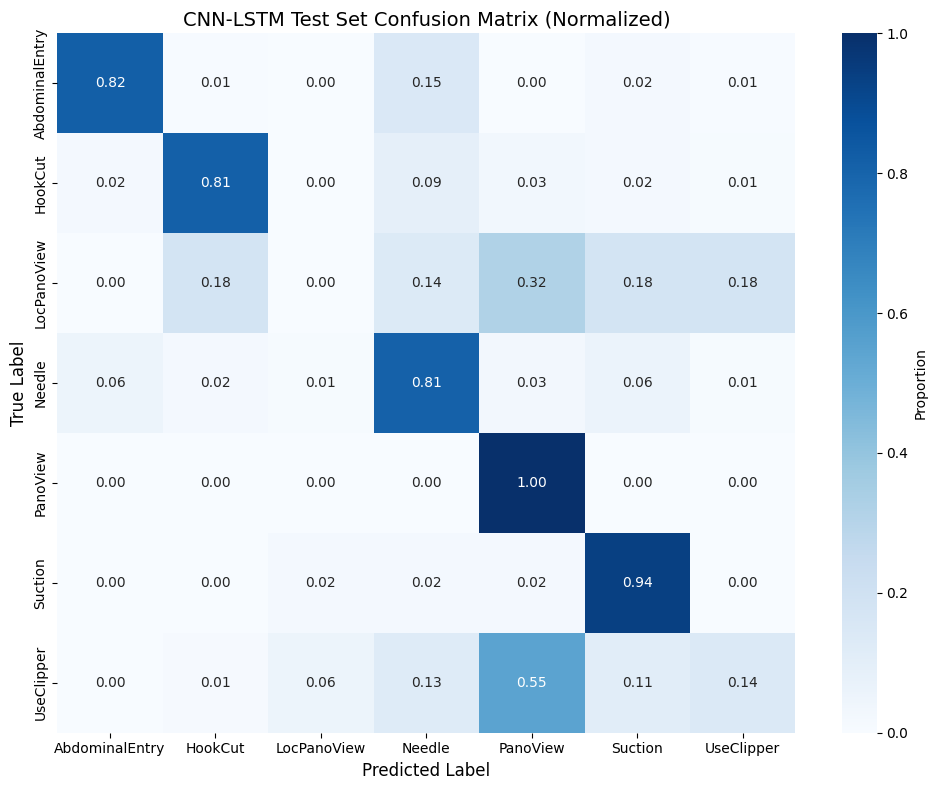

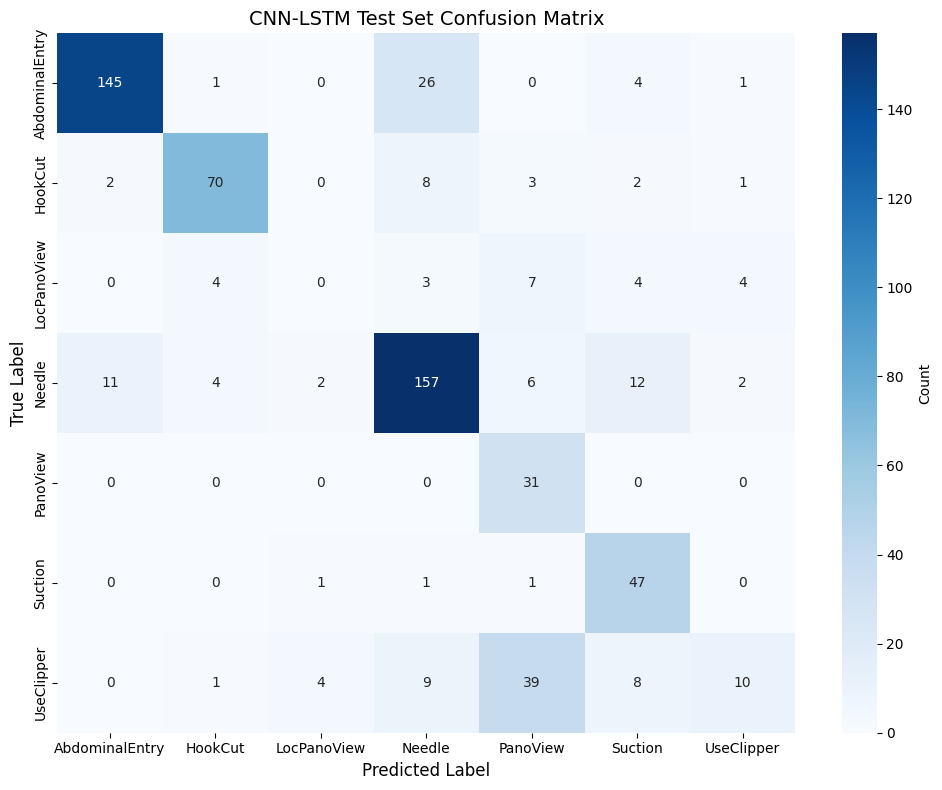


confusion matrices plotted successfully!


In [24]:
# visualize confusion to spot common confusions
print("generating confusion matrices...\n")

# normalized (per-row) shows error patterns independent of class frequency
cm_norm = plot_confusion_matrix(
    y_true, y_pred, 
    class_names=CLASS_NAMES,
    title="CNN-LSTM Test Set Confusion Matrix",
    normalize=True
)

# raw counts highlight absolute error volume
cm_raw = plot_confusion_matrix(
    y_true, y_pred,
    class_names=CLASS_NAMES,
    title="CNN-LSTM Test Set Confusion Matrix",
    normalize=False
)

print("\nconfusion matrices plotted successfully!")

## run speed benchmark

In [25]:
# run the speed benchmark and print a friendly summary
print(f"model: cnn+lstm (resnet18 encoder)")
run_speed_benchmark(model, time_size, test_loader, resize_shape, DEVICE, BATCH_SIZE)


model: cnn+lstm (resnet18 encoder)
inference speed evaluation
device: cuda
batch size: 8
total parameters: 13281351
input shape: (8, 16, 3, 224, 224)

running 5 warmup batches...
benchmarking 50 batches...
benchmarking 50 batches...

speed metrics
total samples processed:     400
total time:                  2.5019 seconds

batch processing:
  mean batch time:           0.0500 ± 0.0033 sec
  min batch time:            0.0408 sec
  max batch time:            0.0561 sec
  median batch time:         0.0510 sec

throughput:
  samples/second (fps):      159.88
  batches/second:            19.98

latency (per sample):
  mean latency:              6.25 ms
  mean sample time:          0.0063 sec

frame-level statistics:
  total frames processed:    6400
  frames/second:             2558.08
  time per frame:            0.3909 ms


speed metrics
total samples processed:     400
total time:                  2.5019 seconds

batch processing:
  mean batch time:           0.0500 ± 0.0033 sec
  min b

# ResNetTSM Inference

## evaluation + metrics

In [26]:

from tsm_resnet_new import ResNetTSM

print("\nInitializing ResNet18-TSM")
tsm_model = ResNetTSM(
    num_classes=7,
    num_segments=16,
    pretrained=True,
).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

checkpoint = "/home/zhadiger/Desktop/data_preprocessing/best_tsm_resnet.pth"

# **LOAD EXISTING CHECKPOINT FOR RGB STREAM**
print(f"\nLoading existing checkpoint: {checkpoint}")
try:
    tsm_model = tsm_model.load_tsm_from_checkpoint(
        ckpt_path=checkpoint,
        num_classes=7,
        num_segments=16,
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        freeze_until="layer2",
        pretrained=True,
    )
    print(" Loaded model from checkpoint")
except Exception as e:
    print(f"Warning: Could not load checkpoint: {e}")
    print("Training from scratch instead")

# evaluate on the test set and print metrics
y_true, y_pred = evaluation(test_ds, test_loader, tsm_model, DEVICE, CLASS_NAMES)

   


Initializing ResNet18-TSM

Loading existing checkpoint: /home/zhadiger/Desktop/data_preprocessing/best_tsm_resnet.pth
 Loaded model from checkpoint
starting evaluation on test set...
evaluating 631 samples...


/home/zhadiger/Desktop/data_preprocessing/tsm_resnet_new.py:168: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)



predictions collected:
  true labels shape: (631,)
  predictions shape: (631,)
  logits shape: (631, 7)

Test Set Metrics Summary
Accuracy:           0.6054

Macro Metrics:
  Precision:        0.5655
  Recall:           0.6124
  F1-Score:         0.5567

Weighted Metrics:
  Precision:        0.6920
  Recall:           0.6054
  F1-Score:         0.6278

Micro F1-Score:     0.6054


per-class metrics:
Class                Precision    Recall       F1-Score     Support   
AbdominalEntry       0.8559       0.5706       0.6847       177       
HookCut              0.9146       0.8721       0.8929       86        
LocPanoView          0.0684       0.3636       0.1151       22        
Needle               0.7578       0.6289       0.6873       194       
PanoView             0.7073       0.9355       0.8056       31        
Suction              0.4943       0.8600       0.6277       50        
UseClipper           0.1600       0.0563       0.0833       71        

evaluation complete!


## confusion matrix

generating confusion matrices...



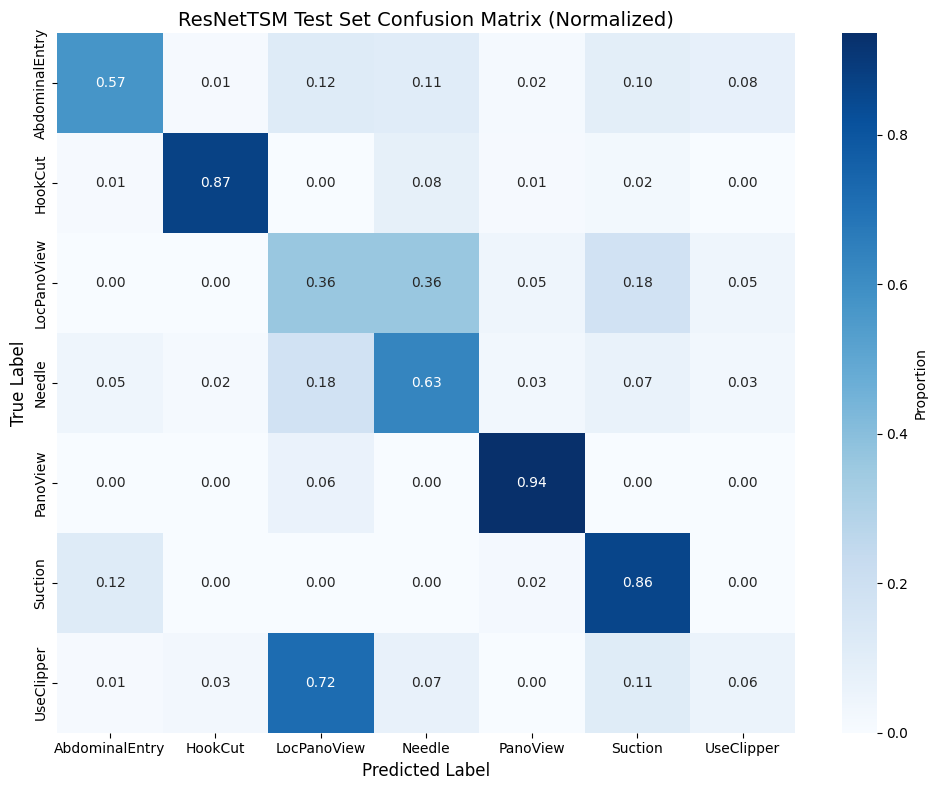

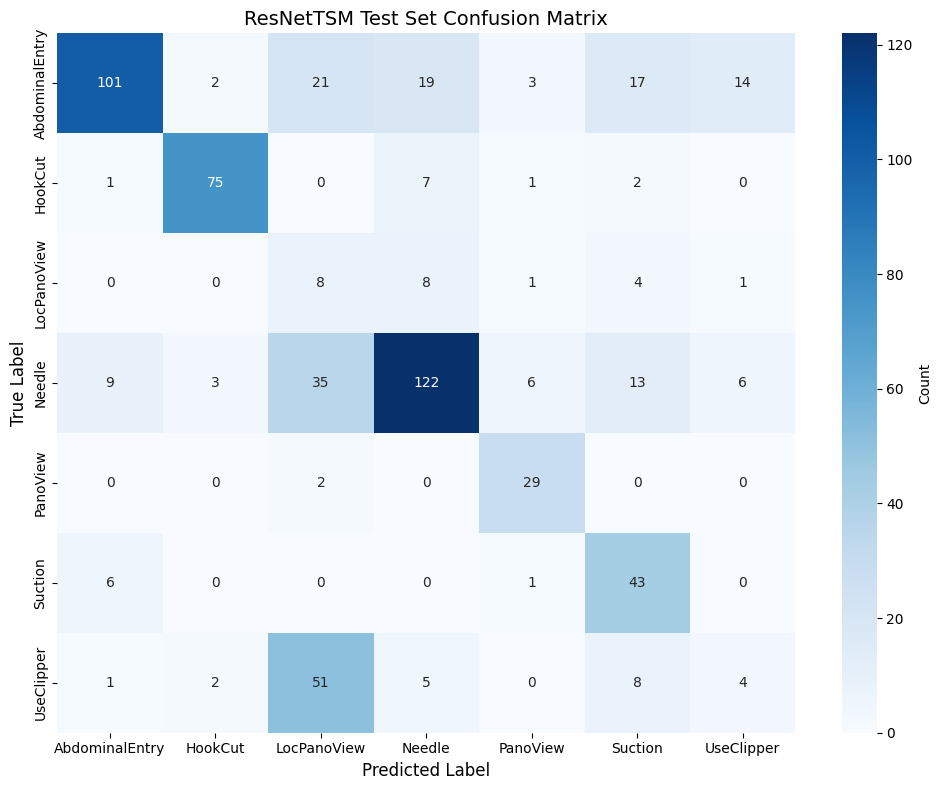


confusion matrices plotted successfully!


In [27]:
# visualize confusion to spot common confusions
print("generating confusion matrices...\n")

# normalized (per-row) shows error patterns independent of class frequency
cm_norm = plot_confusion_matrix(
    y_true, y_pred, 
    class_names=CLASS_NAMES,
    title="ResNetTSM Test Set Confusion Matrix",
    normalize=True
)

# raw counts highlight absolute error volume
cm_raw = plot_confusion_matrix(
    y_true, y_pred,
    class_names=CLASS_NAMES,
    title="ResNetTSM Test Set Confusion Matrix",
    normalize=False
)

print("\nconfusion matrices plotted successfully!")

## speed test

In [28]:
# run speed benchmark
print("ResNet18-TSM model inference speed")
run_speed_benchmark(tsm_model, time_size, test_loader, resize_shape, DEVICE, BATCH_SIZE)

ResNet18-TSM model inference speed
inference speed evaluation
device: cuda
batch size: 8
total parameters: 11180103
input shape: (8, 16, 3, 224, 224)

running 5 warmup batches...
benchmarking 50 batches...
benchmarking 50 batches...

speed metrics
total samples processed:     400
total time:                  2.5107 seconds

batch processing:
  mean batch time:           0.0502 ± 0.0025 sec
  min batch time:            0.0425 sec
  max batch time:            0.0535 sec
  median batch time:         0.0507 sec

throughput:
  samples/second (fps):      159.32
  batches/second:            19.91

latency (per sample):
  mean latency:              6.28 ms
  mean sample time:          0.0063 sec

frame-level statistics:
  total frames processed:    6400
  frames/second:             2549.11
  time per frame:            0.3923 ms


speed metrics
total samples processed:     400
total time:                  2.5107 seconds

batch processing:
  mean batch time:           0.0502 ± 0.0025 sec
  min b

# R(2+1)D Inference 

## evaluation + metrics

In [ ]:

import importlib.util, os, torch, sys
from pathlib import Path
import torch.nn as nn
import torchvision


R2_PTH = "/home/zhadiger/Desktop/data_preprocessing/checkpoints/best_r2plus1d.pth"
local_r2_file = "/home/zhadiger/Desktop/data_preprocessing/r2plus1d_resnet.py"

def _load_local_module(path, name):
    spec = importlib.util.spec_from_file_location(name, path)
    mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(mod)
    return mod

# Guard prerequisites
_required = ['test_loader', 'benchmark_inference', 'DEVICE', 'time_size']
missing = [v for v in _required if v not in globals()]
if missing:
    print("Missing required objects to run R(2+1)D benchmark:", missing)
    print("Please run earlier notebook cells that define the dataloader and benchmark function.")
elif not os.path.exists(R2_PTH):
    print(f"R(2+1)D checkpoint not found at {R2_PTH}. Please check path.")
else:
    # Try local implementation first, otherwise use torchvision's model
    r2_model = None
    local_found = False
    if os.path.exists(local_r2_file):
        try:
            lm = _load_local_module(local_r2_file, 'local_r2')
            # heuristics: find a class that looks like R2Plus1D implementation
            candidates = [name for name in dir(lm) if name.lower().startswith('r2') or 'r2' in name.lower()]
            # print found candidates for transparency
            print('Found candidate model classes in module:', candidates)
            for cand in candidates:
                cls = getattr(lm, cand)
                try:
                    # try instantiation with common signature
                    inst = cls(num_classes=getattr(globals(), 'num_classes', 7), num_segments=getattr(globals(), 'time_size', 16))
                    r2_model = inst
                    local_found = True
                    print(f'Instantiated local R2 model class: {cand}')
                    break
                except Exception as e:
                    continue
        except Exception as e:
            print('Failed to import local r2plus1d_resnet.py:', e)

    if not local_found:
        # Fallback: torchvision r2plus1d_18 - wrap to accept (B,T,C,H,W)
        try:
            print('Using torchvision r2plus1d_18 fallback')
            base = torchvision.models.video.r2plus1d_18(pretrained=False)
            in_feat = base.fc.in_features
            base.fc = nn.Linear(in_feat, getattr(globals(), 'num_classes', 7))
            # wrapper to permute input from (B,T,C,H,W) -> (B,C,T,H,W) expected by torchvision models
            class Wrapper(nn.Module):
                def __init__(self, m):
                    super().__init__()
                    self.m = m
                def forward(self, x):
                    # x: B, T, C, H, W -> B, C, T, H, W
                    x = x.permute(0,2,1,3,4)
                    return self.m(x)
            r2_model = Wrapper(base)
        except Exception as e:
            raise RuntimeError('No R2 model available and torchvision import failed: '+str(e))

    # Move model to device, load weights if possible
    r2_model = r2_model.to(DEVICE)
    r2_model.eval()

    # Load checkpoint and try to load state dict robustly
    try:
        ckpt = torch.load(R2_PTH, map_location='cpu')
        state = None
        if isinstance(ckpt, dict):
            # common keys: 'model', 'state_dict', or full checkpoint
            for key in ('model','state_dict','state_dict_encoder','net'):
                if key in ckpt:
                    state = ckpt[key]
                    break
            if state is None:
                # sometimes checkpoint directly contains keys of state dict (i.e., it's a state_dict)
                state = ckpt
        else:
            state = ckpt
        # attempt strict=False first to allow prefix mismatches
        try:
            r2_model.load_state_dict(state, strict=False)
            print('Loaded checkpoint into R2 model (strict=False).')
        except Exception as e:
            # try mapping keys if they have module prefix like 'module.'
            new_state = {}
            for k,v in state.items():
                nk = k.replace('module.', '')
                new_state[nk] = v
            r2_model.load_state_dict(new_state, strict=False)
            print('Loaded checkpoint into R2 model after key cleanup (strict=False).')
    except Exception as e:
        print('Warning: failed to load checkpoint weights:', e)

    y_true, y_pred = evaluation(test_ds, test_loader, r2_model, DEVICE, CLASS_NAMES)
    

Found candidate model classes in module: ['R2Plus1D_18_Weights', 'ResNetR2Plus1D', 'group_params_r2plus1d', 'r2plus1d_18']
Instantiated local R2 model class: ResNetR2Plus1D
Loaded checkpoint into R2 model (strict=False).
starting evaluation on test set...
evaluating 631 samples...
Instantiated local R2 model class: ResNetR2Plus1D
Loaded checkpoint into R2 model (strict=False).
starting evaluation on test set...
evaluating 631 samples...


/tmp/ipykernel_1124905/3838853894.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(R2_PTH, map_location='cpu')



predictions collected:
  true labels shape: (631,)
  predictions shape: (631,)
  logits shape: (631, 7)

Test Set Metrics Summary
Accuracy:           0.6054

Macro Metrics:
  Precision:        0.5655
  Recall:           0.6124
  F1-Score:         0.5567

Weighted Metrics:
  Precision:        0.6920
  Recall:           0.6054
  F1-Score:         0.6278

Micro F1-Score:     0.6054


per-class metrics:
Class                Precision    Recall       F1-Score     Support   
AbdominalEntry       0.8559       0.5706       0.6847       177       
HookCut              0.9146       0.8721       0.8929       86        
LocPanoView          0.0684       0.3636       0.1151       22        
Needle               0.7578       0.6289       0.6873       194       
PanoView             0.7073       0.9355       0.8056       31        
Suction              0.4943       0.8600       0.6277       50        
UseClipper           0.1600       0.0563       0.0833       71        

evaluation complete!


## confusion matrix

generating confusion matrices...



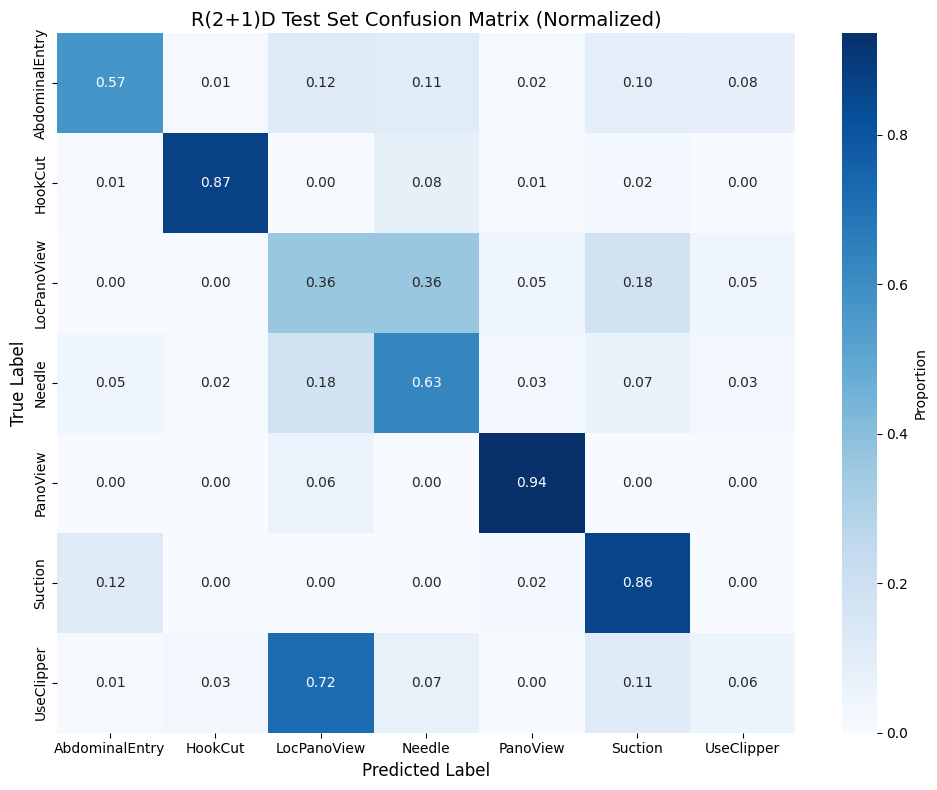

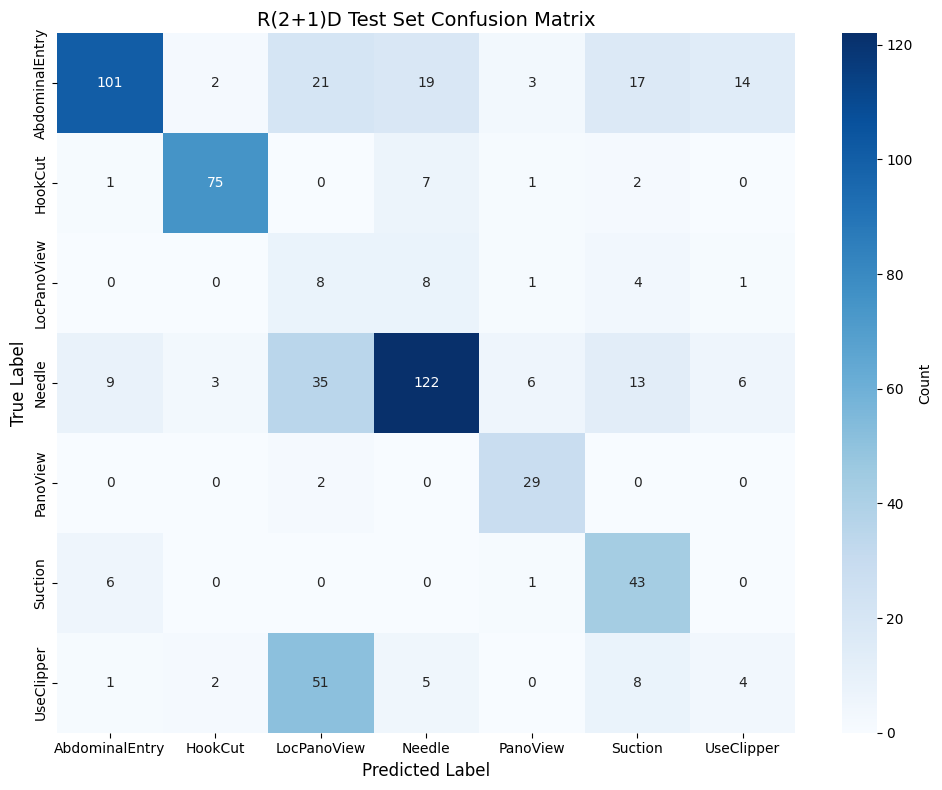


confusion matrices plotted successfully!


In [46]:
# visualize confusion to spot common confusions
print("generating confusion matrices...\n")

# normalized (per-row) shows error patterns independent of class frequency
cm_norm = plot_confusion_matrix(
    y_true, y_pred, 
    class_names=CLASS_NAMES,
    title="R(2+1)D Test Set Confusion Matrix",
    normalize=True
)

# raw counts highlight absolute error volume
cm_raw = plot_confusion_matrix(
    y_true, y_pred,
    class_names=CLASS_NAMES,
    title="R(2+1)D Test Set Confusion Matrix",
    normalize=False
)

print("\nconfusion matrices plotted successfully!")

## speed test

In [43]:
print('Running R(2+1)D inference benchmark (warmup=5, batches=50)...')
run_speed_benchmark(r2_model, time_size, test_loader, resize_shape, DEVICE, BATCH_SIZE)

Running R(2+1)D inference benchmark (warmup=5, batches=50)...
inference speed evaluation
device: cuda
batch size: 8
total parameters: 31303716
input shape: (8, 16, 3, 224, 224)

running 5 warmup batches...
benchmarking 50 batches...
benchmarking 50 batches...

speed metrics
total samples processed:     400
total time:                  19.2153 seconds

batch processing:
  mean batch time:           0.3843 ± 0.0154 sec
  min batch time:            0.3681 sec
  max batch time:            0.4223 sec
  median batch time:         0.3806 sec

throughput:
  samples/second (fps):      20.82
  batches/second:            2.60

latency (per sample):
  mean latency:              48.04 ms
  mean sample time:          0.0480 sec

frame-level statistics:
  total frames processed:    6400
  frames/second:             333.07
  time per frame:            3.0024 ms


speed metrics
total samples processed:     400
total time:                  19.2153 seconds

batch processing:
  mean batch time:           

# ViViT Inference

# evaluation + metrics

In [53]:

import importlib.util, os, torch, sys
from pathlib import Path
import types
from cnn_model import ViViT

VIVIT_CHECKPOINT = "/home/zhadiger/Desktop/data_preprocessing/best_model_224_BS2_FR16_val_acc_0.4568.pkl"
VIVIT_MODULE = "/home/zhadiger/Desktop/data_preprocessing/SLAM-Vivit_Cls/cnn_model.py"


vivit_model = ViViT(224, 16, 7, time_size)
vivit_model.load_state_dict(torch.load(VIVIT_CHECKPOINT), strict=False)
vivit_model.to(DEVICE)

# evaluation
y_true, y_pred = evaluation(test_ds, test_loader, vivit_model, DEVICE, CLASS_NAMES)


starting evaluation on test set...
evaluating 631 samples...


/tmp/ipykernel_1124905/1978385168.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vivit_model.load_state_dict(torch.load(VIVIT_CHECKPOINT), strict=False)



predictions collected:
  true labels shape: (631,)
  predictions shape: (631,)
  logits shape: (631, 7)

Test Set Metrics Summary
Accuracy:           0.3946

Macro Metrics:
  Precision:        0.3210
  Recall:           0.3238
  F1-Score:         0.3146

Weighted Metrics:
  Precision:        0.4069
  Recall:           0.3946
  F1-Score:         0.3931

Micro F1-Score:     0.3946


per-class metrics:
Class                Precision    Recall       F1-Score     Support   
AbdominalEntry       0.4688       0.3390       0.3934       177       
HookCut              0.5045       0.6512       0.5685       86        
LocPanoView          0.0000       0.0000       0.0000       22        
Needle               0.4901       0.5103       0.5000       194       
PanoView             0.3200       0.2581       0.2857       31        
Suction              0.3582       0.4800       0.4103       50        
UseClipper           0.1053       0.0282       0.0444       71        

evaluation complete!


## confusion matrix

generating confusion matrices...



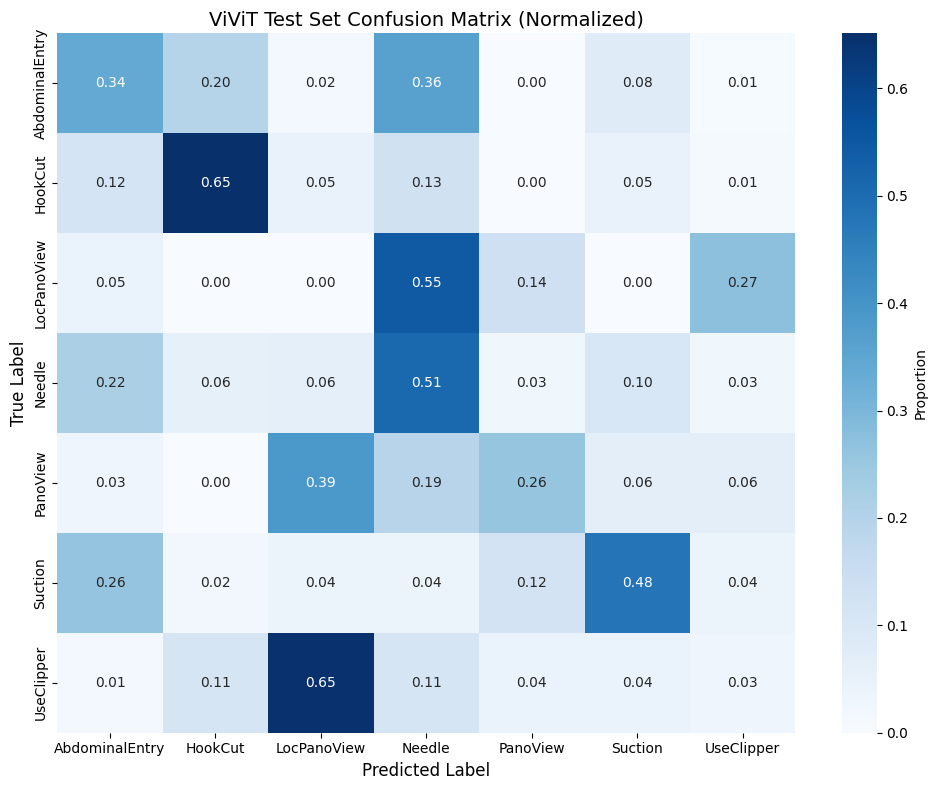

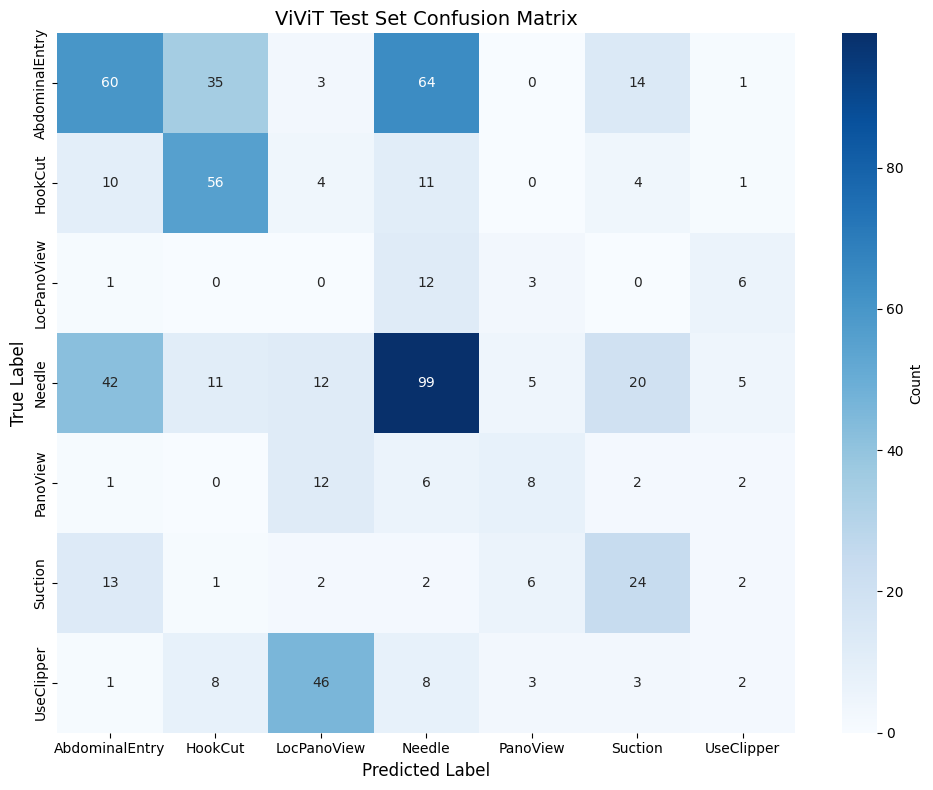


confusion matrices plotted successfully!


In [54]:
# visualize confusion to spot common confusions
print("generating confusion matrices...\n")

# normalized (per-row) shows error patterns independent of class frequency
cm_norm = plot_confusion_matrix(
    y_true, y_pred, 
    class_names=CLASS_NAMES,
    title="ViViT Test Set Confusion Matrix",
    normalize=True
)

# raw counts highlight absolute error volume
cm_raw = plot_confusion_matrix(
    y_true, y_pred,
    class_names=CLASS_NAMES,
    title="ViViT Test Set Confusion Matrix",
    normalize=False
)

print("\nconfusion matrices plotted successfully!")

## speed test

In [55]:
print("ViViT Inference speed ")
run_speed_benchmark(vivit_model, time_size, test_loader, resize_shape, DEVICE, BATCH_SIZE)

ViViT Inference speed 
inference speed evaluation
device: cuda
batch size: 8
total parameters: 10785799
input shape: (8, 16, 3, 224, 224)

running 5 warmup batches...
benchmarking 50 batches...
benchmarking 50 batches...

speed metrics
total samples processed:     400
total time:                  1.3218 seconds

batch processing:
  mean batch time:           0.0264 ± 0.0013 sec
  min batch time:            0.0236 sec
  max batch time:            0.0291 sec
  median batch time:         0.0265 sec

throughput:
  samples/second (fps):      302.61
  batches/second:            37.83

latency (per sample):
  mean latency:              3.30 ms
  mean sample time:          0.0033 sec

frame-level statistics:
  total frames processed:    6400
  frames/second:             4841.76
  time per frame:            0.2065 ms


speed metrics
total samples processed:     400
total time:                  1.3218 seconds

batch processing:
  mean batch time:           0.0264 ± 0.0013 sec
  min batch time:  

# ResNetTSM with Optical Flow Inference

## evaluation + metrics

In [62]:
from optical_flow import ResNetTSM_OF

print("\nInitializing ResNet18-TSM (Two-Stream, On-the-Fly Flow)...")
of_model = ResNetTSM_OF(
    num_classes=7,
    num_segments=16,
    depth=18,
    pretrained=True,
    use_flow=True,
).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

checkpoint = "/home/zhadiger/Desktop/data_preprocessing/best_model_twostream.pth"
# **LOAD EXISTING CHECKPOINT FOR RGB STREAM**
print(f"\nLoading existing checkpoint: {checkpoint}")
try:
    checkpoint = torch.load(checkpoint, map_location='cuda' if torch.cuda.is_available() else 'cpu')

    # Load RGB stream weights
    rgb_keys = [k for k in checkpoint.keys() if not k.startswith('flow_') and not k.startswith('fusion')]
    rgb_checkpoint = {k: checkpoint[k] for k in rgb_keys if k in of_model.state_dict()}
    of_model.load_state_dict(rgb_checkpoint, strict=False)
    print(" Loaded RGB stream from checkpoint")
except Exception as e:
    print(f"Warning: Could not load checkpoint: {e}")
    print("Training from scratch instead")

y_true, y_pred = evaluation(test_ds, test_loader, of_model, DEVICE, CLASS_NAMES)


Device: cuda
Loading checkpoint from: /home/zhadiger/Desktop/data_preprocessing/best_model_twostream.pth
Checkpoint Directory: .

Initializing ResNet18-TSM (Two-Stream, On-the-Fly Flow)...

Loading existing checkpoint: /home/zhadiger/Desktop/data_preprocessing/best_model_twostream.pth
 Loaded RGB stream from checkpoint
starting evaluation on test set...
evaluating 631 samples...
 Loaded RGB stream from checkpoint
starting evaluation on test set...
evaluating 631 samples...


/tmp/ipykernel_1124905/2309623143.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint, map_location='cuda' if torch.cuda.is_available() e


predictions collected:
  true labels shape: (631,)
  predictions shape: (631,)
  logits shape: (631, 7)

Test Set Metrics Summary
Accuracy:           0.0143

Macro Metrics:
  Precision:        0.0123
  Recall:           0.0119
  F1-Score:         0.0094

Weighted Metrics:
  Precision:        0.0226
  Recall:           0.0143
  F1-Score:         0.0160

Micro F1-Score:     0.0143


per-class metrics:
Class                Precision    Recall       F1-Score     Support   
AbdominalEntry       0.0769       0.0395       0.0522       177       
HookCut              0.0065       0.0116       0.0083       86        
LocPanoView          0.0000       0.0000       0.0000       22        
Needle               0.0000       0.0000       0.0000       194       
PanoView             0.0028       0.0323       0.0051       31        
Suction              0.0000       0.0000       0.0000       50        
UseClipper           0.0000       0.0000       0.0000       71        

evaluation complete!


## confusion matrix

Generating confusion matrices...



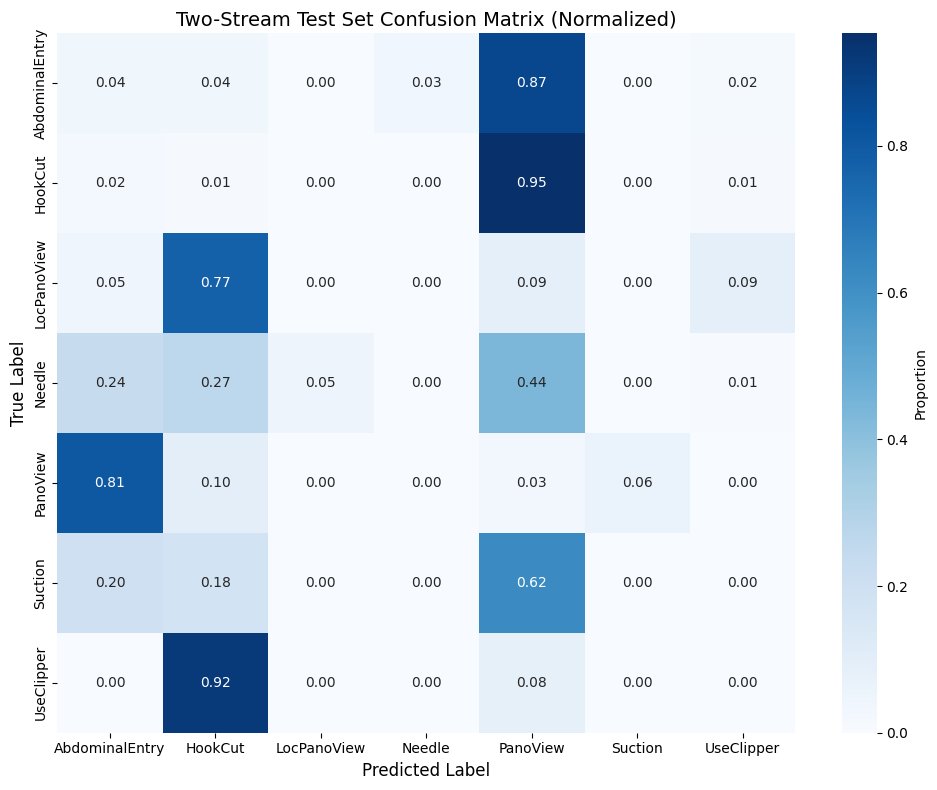

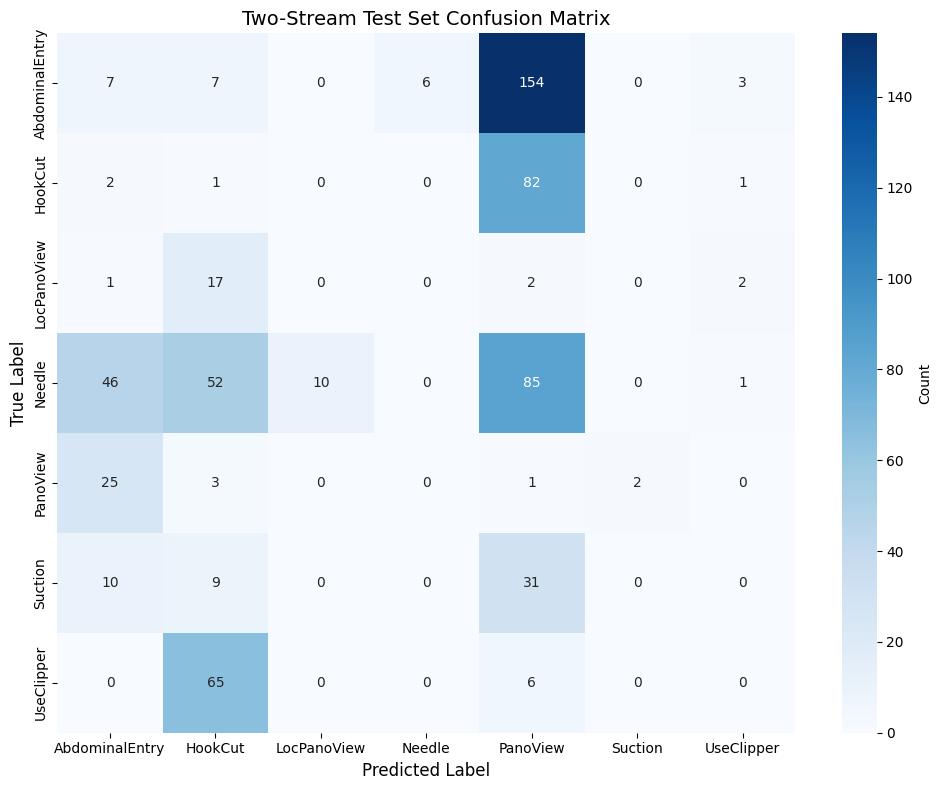


Confusion matrices plotted successfully!


In [63]:
# Plot confusion matrices
print("Generating confusion matrices...\n")

# Plot normalized confusion matrix
cm_norm = plot_confusion_matrix(
    y_true, y_pred, 
    class_names=CLASS_NAMES,
    title="Two-Stream Test Set Confusion Matrix",
    normalize=True
)

# Plot raw count confusion matrix
cm_raw = plot_confusion_matrix(
    y_true, y_pred,
    class_names=CLASS_NAMES,
    title="Two-Stream Test Set Confusion Matrix",
    normalize=False
)

print("\nConfusion matrices plotted successfully!")

## speed test

In [64]:
# speed test
print("ResNetTSM with Optical Flow Inference speed ")
run_speed_benchmark(of_model, time_size, test_loader, resize_shape, DEVICE, BATCH_SIZE)

ResNetTSM with Optical Flow Inference speed 
inference speed evaluation
device: cuda
batch size: 8
total parameters: 11581831
input shape: (8, 16, 3, 224, 224)

running 5 warmup batches...
benchmarking 50 batches...
benchmarking 50 batches...

speed metrics
total samples processed:     400
total time:                  2.6631 seconds

batch processing:
  mean batch time:           0.0533 ± 0.0180 sec
  min batch time:            0.0407 sec
  max batch time:            0.0928 sec
  median batch time:         0.0441 sec

throughput:
  samples/second (fps):      150.20
  batches/second:            18.78

latency (per sample):
  mean latency:              6.66 ms
  mean sample time:          0.0067 sec

frame-level statistics:
  total frames processed:    6400
  frames/second:             2403.21
  time per frame:            0.4161 ms


speed metrics
total samples processed:     400
total time:                  2.6631 seconds

batch processing:
  mean batch time:           0.0533 ± 0.0180 s